## Limit Flux To Core example notebook

Tyler W. H. Backman

Required inputs:
* input model
* exchange fluxes including biomass, and carbon feed uptake
* list of reactions which are considered 'core' reactions

Output produced:
* an updated version of the input model, where flux bounds are set to minimize fluxes into core, compatible with the exchange fluxes

In [1]:
import lftc
import cobra
import re
import os
import tempfile
import math
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:1,.5f}'.format # don't use scientific notation in output

Import SBML model

In [2]:
model = cobra.io.read_sbml_model('test_data/EciJR904TKs_sbml3.xml')

Set exchange fluxes to experimental values from Toya2010 wt5h 

In [3]:
model.reactions.EX_glc_e_.lower_bound = -11.7
model.reactions.EX_glc_e_.upper_bound = -11.7
model.reactions.EX_ac_e_.lower_bound = 4.3
model.reactions.EX_ac_e_.upper_bound = 4.3
model.reactions.BiomassEcoli.lower_bound = 0.83
model.reactions.BiomassEcoli.upper_bound = 0.89

Read in the jQMM formatted atom transitions to get the reaction core

In [4]:
with open('test_data/REACTIONSwt5h.txt') as f:
    allLines = f.readlines()
reactionLines = list(filter(lambda l: re.match('^\w', l), allLines))
coreReactionNamesFromFile = set([re.sub('\s.*$', '', l) for l in reactionLines])
coreReactionNamesFromFile = set([re.sub('[\(,\)]', '_', l) for l in coreReactionNamesFromFile])
coreReactionNames = coreReactionNamesFromFile.intersection([r.id for r in model.reactions])

print(str(len(coreReactionNamesFromFile)) + ' core reactions in transitions file')
print(str(len(coreReactionNames)) + ' overlapping with model')
print('missing from model: ', coreReactionNamesFromFile.difference(coreReactionNames))

127 core reactions in transitions file
127 overlapping with model
missing from model:  set()


Run Limit Flux To Core to determine the sum of fluxes into core required to satisfy the exchanges

In [5]:
fluxIntoCore, producingFluxes, consumingFluxes = lftc.limitFluxToCore(coreReactionNames, model)
fluxIntoCore

3.1875701799999803

Show all fluxes into the core where the upper bound could not be set to zero

In [6]:
# optionally write these fluxes to a csv file
# producingFluxesNonZero = producingFluxes[producingFluxes > 0]
# producingFluxesNonZero.to_csv('test_data/new_fluxes.csv')

producingFluxes[producingFluxes > 0]

DB4PS     0.00002
IG3PS     0.07470
HSTPT     0.07470
IMPD      0.23108
METS      0.12118
GTPCI     0.04150
ADCL      0.04150
ADCS      0.04150
GARFT     0.34933
ANS       0.04482
SDPDS     0.29349
AICART    0.47136
OMCDC     0.35524
CYSS      0.19344
UHGADA    0.01394
GTPCII2   0.00001
CYSTL     0.12118
SHSL1     0.12118
UNK3      0.00581
THDPS     0.29349
MOHMT     0.00005
DKMPPD    0.00581
CTPS2     0.12566
GF6PTA    0.05976
DHFR      0.06200
TRPS1     0.04482
Name: fluxes, dtype: float64

Show all reversible fluxes out of core where the lower bound could not be set to zero

In [7]:
consumingFluxes[consumingFluxes < 0]

Series([], Name: fluxes, dtype: float64)

Write model with new bounds to a new file

In [8]:
updatedModel = lftc.setModelFluxes(model, producingFluxes, consumingFluxes)
cobra.io.write_sbml_model(updatedModel, 'test_data/EciJR904TKs_sbml3_fluxbounds.xml', use_fbc_package=True)

# also write old sbml2 format
# cobra.io.sbml.write_cobra_model_to_sbml_file(updatedModel, 'test_data/EciJR904TKs_sbml2_fluxbounds.xml', sbml_level=2, sbml_version=1,use_fbc_package=False)

Setup simulated annealing problem to identify an improved core, while keeping at least 80% of the initial core

In [9]:
exchanges = [r.id for r in model.exchanges]
logFile = tempfile.mktemp()
ocp = lftc.OptimalCoreProblem(
    state=coreReactionNames,
    model=model, 
    feed='EX_glc_e_',
    minOverlapWithStart=0.8,
    logFile=logFile,
    excludeReactions=exchanges,
    )
ocp.energy()

3.1875701799999803

Run simulated annealing problem to find an improved core, and print out it's size and score

In [10]:
schedule = {'steps': 20000, 'tmax': 50000, 'tmin': 0.01, 'updates': 1000}
ocp.set_schedule(schedule)
coreReactions, score = ocp.anneal(seed=42)
ocp.logFile.close()
print(len(coreReactions))
print(score)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.01000          0.22    75.00%     5.00%     0:39:04     0:00:00

766
0.21634697


Plot the simulated annealing trace

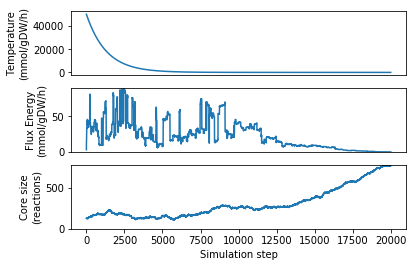

In [11]:
# read in and delete logfile
df = pd.read_csv(logFile)
os.unlink(logFile)

# set temp schedule to match generated results
Tfactor = -math.log(schedule['tmax'] / schedule['tmin'])
annealingSchedule = [schedule['tmax'] * math.exp(Tfactor * step / df.shape[0]) for step in range(0,df.shape[0])]

# plot the data
%matplotlib inline
plt.figure(1)
plt.subplot(311)
plt.plot(annealingSchedule)
plt.ylabel('Temperature\n(mmol/gDW/h)')
plt.subplot(311).axes.get_xaxis().set_visible(False)
plt.subplot(312)
plt.plot(df['energy'])
plt.ylabel('Flux Energy\n(mmol/gDW/h)')
plt.ylim([0,max(df['energy'])])
plt.subplot(312).axes.get_xaxis().set_visible(False)
plt.subplot(313)
plt.plot(df['size'])
plt.ylim([0,max(df['size'])])
plt.ylabel('Core size\n(reactions)')
plt.xlabel('Simulation step')